# 1- IMPORT & get data

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, auc
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)
from helpers.helpers import df_info, iqr_values, plot_importance, error_metrics

In [2]:
# read data

final_df = pd.read_csv(r"data/final_df/final_df.csv")
final_df.head()

In [3]:
# df info

df_info(final_df)

                               nunique  isnull    type
Unnamed: 0                       23887       0   int64
Car Name                          9247       0  object
Exterior color                    2136       0  object
Interior color                    1054       0  object
Drivetrain                          11       0  object
MPG                                428     800  object
Fuel type                           14       0  object
Transmission                       206       0  object
Engine                            1290       0  object
VIN                              23887       0  object
Stock #                          23547     195  object
Mileage                          21314       0  object
Convenience                        188    4028  object
Entertainment                       54    1645  object
Exterior                            15    1733  object
Safety                             133     854  object
Seating                              7    5800  object
Accidents 

* * *

# 2- Data Preparation

As you can see in the photo below, we have scraped the variables as text. Now we will parse the variables we need from the scraped text.

Year | Brand | Model | Mileage | Price:

![x](images/1.jpg)

In [296]:
# year, brand & variables

for index, val in enumerate(final_df["Car Name"]):
    value = val.split(" ")
    final_df.at[index, "Year"] = int(value[0])
    final_df.at[index, "Brand"] = value[1]
    val_list = value[2:]
    final_df.at[index, "Model"] = ' '.join(str(element) for element in val_list)

features list:

![x](images/3.jpg)

In [297]:
# "Convenience", "Entertainment", "Exterior", "Safety", "Seating" are including a lot of different variables

features = [
    "Adaptive Cruise Control",
    "Heated Seats",
    "Navigation System",
    "Power Liftgate",
    "Remote Start",
    "Keyless Start",
    "Apple CarPlay/Android Auto",
    "Bluetooth",
    "USB Port", 
    "Alloy Wheels",
    "Sunroof/Moonroof", 
    "Automatic Emergency Braking",
    "Backup Camera",
    "Stability Control",
    "Leather Seats",
    "Memory Seat",
    "Third Row Seating",
    "Automatic Emergency Braking",
    "Backup Camera",
    "Stability Control",
]

def get_feature(dataframe, features):
    list_ = ["Convenience", "Entertainment", "Exterior", "Safety", "Seating"]

    for i in features:
        dataframe[i] = 0

    for col in list_:
        for index, value in enumerate(dataframe[col]):
            for i in features:
                if i in str(value):
                    dataframe[i].at[index] = 1

    dataframe.drop(["Convenience", "Entertainment", "Exterior", "Safety", "Seating"], axis=1, inplace=True)

get_feature(dataframe=final_df, features=features)

In [298]:
# MPG
for index, val in enumerate(final_df["MPG"]):
    try:
        value = val.split("\n")
        final_df.at[index, "MPG"] = value[0]
    except:
        continue

In [299]:
# turbo yes or no?
final_df["Turbo"] = 0

for index, val in enumerate(final_df["Engine"]):
    try:
        value = val.split("L")
        final_df.at[index, "Engine Size"] = float(value[0][-4:])
        if "Turbo" in val:
            final_df.at[index, "Turbo"] = 1
    except:
        continue

In [300]:
# Automatic Transmission yes or no

final_df["Automatic Transmission"] = 0

for index, val in enumerate(final_df["Transmission"]):
    if "Automatic" in val:
        final_df.at[index, "Automatic Transmission"] = 1

In [301]:
# Mileage 

for index, val in enumerate(final_df["Mileage"]):
    if val[-3:] != "mi.":
        final_df.drop(index, axis=0, inplace=True)
        print("silinen index:", index)
    else:
        value = val.split(" ")
        value_ = value[0].replace(",", "")
        final_df.at[index, "Mileage"] = int(value_)

In [302]:
# drop variables if na values over 15k

for col in final_df.columns:
    if final_df[col].isnull().sum() > 15000:
        try:
            final_df.drop(col, axis=1, inplace=True)
            print("Silinen değişken :", col, " Toplam 'NA' :", final_df[col].isnull().sum())
        except:
            continue

In [303]:
# drop Secondary Price, Car ID, Stock #, Car Name 
 
final_df.drop(["Secondary Price", "Car ID", "Stock #", "Car Name"], axis=1, inplace=True)

In [304]:
# drop "$"

final_df["Primary Price"] = final_df["Primary Price"].apply(lambda x : x[1:].replace(",",""))

In [305]:
# Drivetrain

final_df["Drivetrain"] = final_df["Drivetrain"].apply(lambda x : 'Front-wheel Drive' if x == 'FWD'
                             else 'Rear-wheel Drive' if x == 'RWD'
                             else 'Four-wheel Drive' if x in ['AWD', '4WD', 'All-wheel Drive']
                             else 'Unknown' if x == '–'
                             else x)

In [306]:
# Fuel type 

final_df["Fuel type"] = final_df["Fuel type"].apply(lambda x : 'Hybrid' if x == 'Plug-In Hybrid'
                                                    else 'Unknown' if x in ['–', 'Other', 'Unspecified']
                                                    else x)

* not : 'Premium Unleaded' yüksek oktanlı premium kurşunsuz benzin demek ve lüks araçlarda kullanılırmış.

In [307]:
# any Accidents or damage?

final_df["Accidents or damage"] = final_df["Accidents or damage"].apply(lambda x : 0 if x == 'None reported'
                                                                                     else 1 if x == 'At least 1 accident or damage reported'
                                                                                     else np.nan)

In [308]:
# first owner?

final_df["1-owner vehicle"] = final_df["1-owner vehicle"].apply(lambda x : 1 if x == 'Yes'
                                                                             else 0 if x == 'No'
                                                                             else np.nan)

In [309]:
# personal use ? 

final_df["Personal use only"] = final_df["Personal use only"].apply(lambda x : 1 if x == 'Yes'
                                                                             else 0 if x == 'No'
                                                                             else np.nan)

In [310]:
# min_MPG & max_MPG 

for index, value in enumerate(final_df["MPG"]):
    if "–" in str(value):
        value = str(value)
        value = value.replace("–", "-")  # Düz tireyi ASCII tireye dönüştür
        
        val_list = value.split("-")
        
        if val_list[0] != "":
            val_list[0] = float(val_list[0])
        else:
            val_list[0] = np.nan
        
        if val_list[1] != "":
            val_list[1] = float(val_list[1])
        else:
            val_list[1] = np.nan
        
        final_df.at[index, "min_MPG"] = min(val_list)
        final_df.at[index, "max_MPG"] = max(val_list)
    else:
        final_df.at[index, "min_MPG"] = float(value)
        final_df.at[index, "max_MPG"] = float(value)

final_df.drop("MPG", axis=1, inplace=True)

In [311]:
# '-' içeren tüm satırları na olarak değiştiriyorum

for col in final_df.columns:
    final_df[col] = final_df[col].apply(lambda x : np.nan if x == "–" else x)

* * *

# 3- Feature Engineering

In [5]:
final_df = pd.read_csv("data/final_df/final_df_prepared.csv")

* *
## 3.1- Na values

<Axes: >

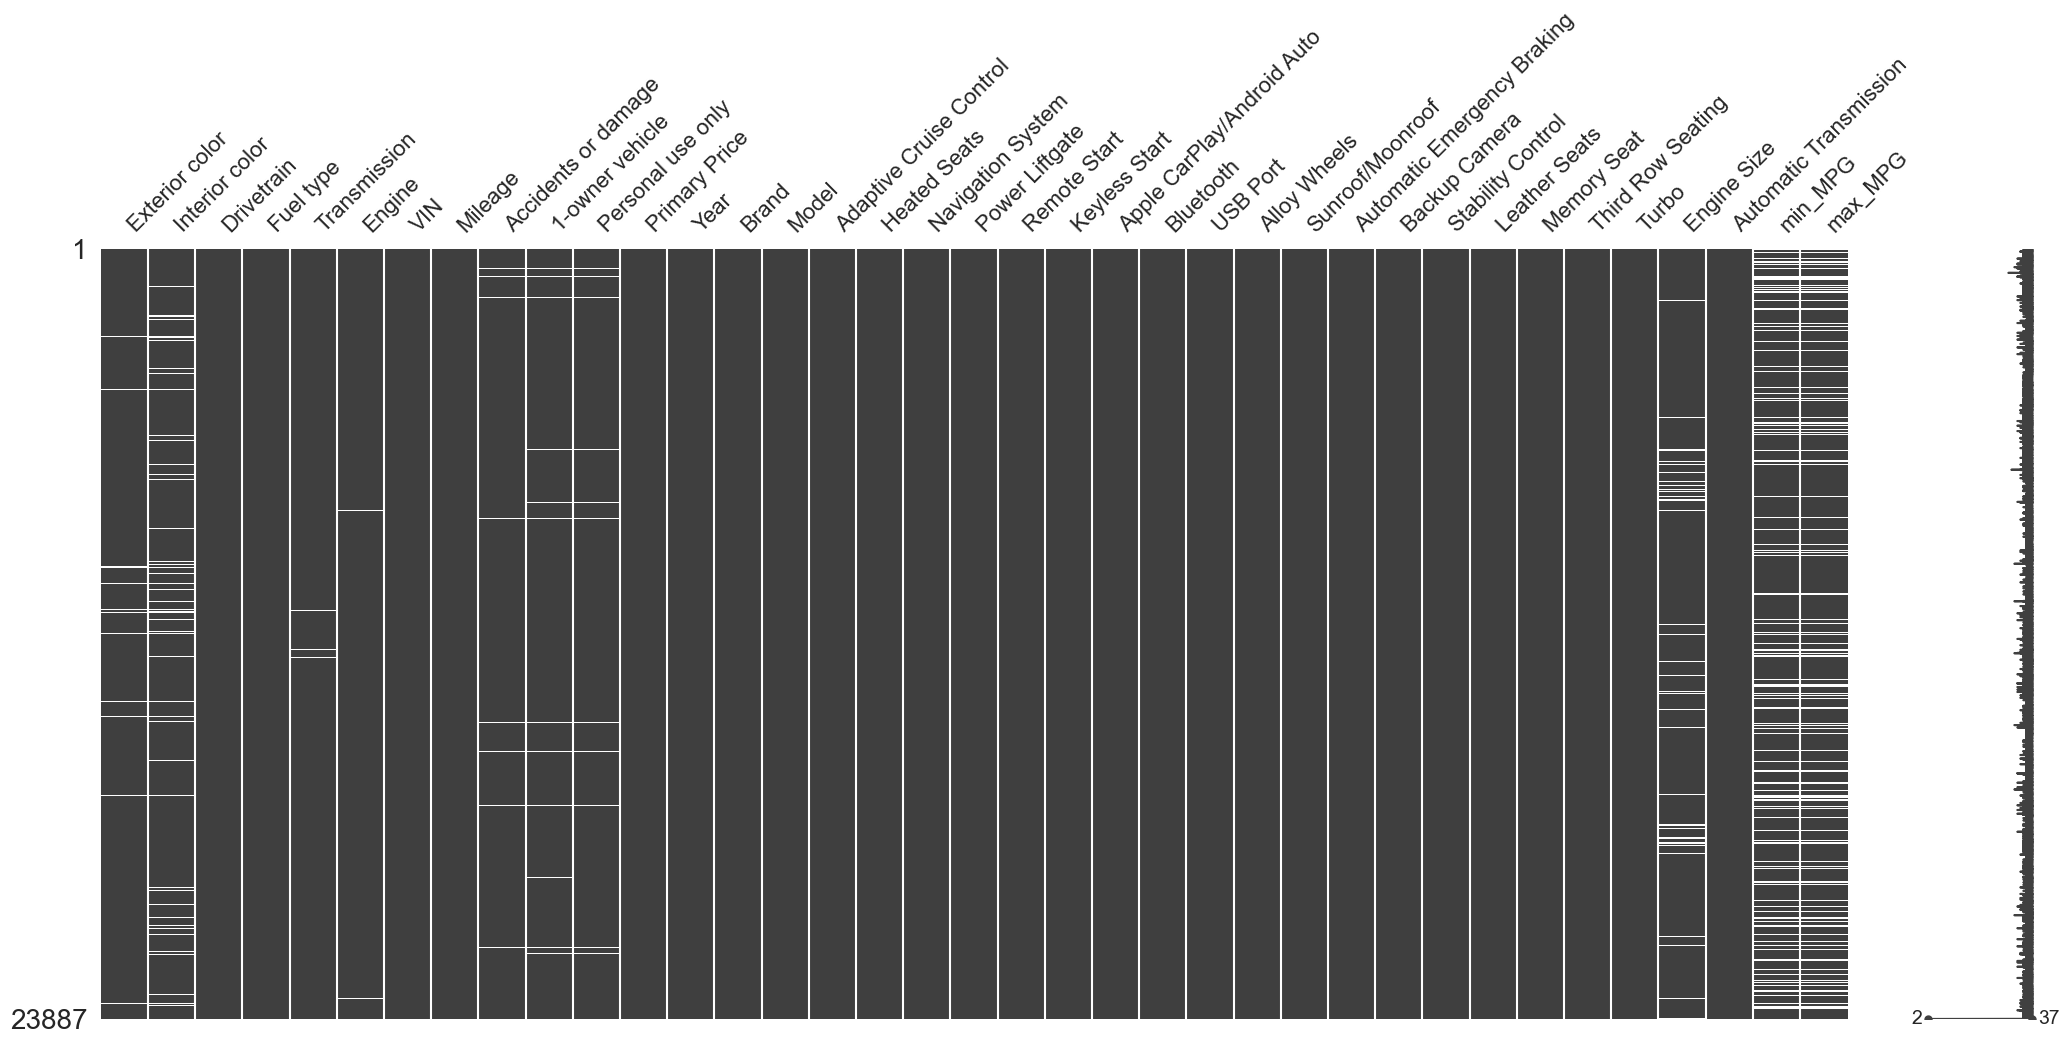

In [314]:
msno.matrix(final_df)

In [6]:
# drop units if not have price value

for index, val in enumerate(final_df["Primary Price"]):
    try:
        final_df.at[index, "Primary Price"] = float(val)
    except:
        final_df.drop(index, axis=0, inplace=True)

final_df["Primary Price"] = final_df["Primary Price"].astype(float)

In [7]:
print("shape before drop 'NA' :", final_df.shape)

for col in final_df.columns:
    if (final_df[col].isnull().sum() < 200) & (final_df[col].isnull().sum() > 0):
        final_df = final_df[final_df[col].isna() == False]

print("shape after drop 'NA' :", final_df.shape)

shape before drop 'NA' : (23846, 37)
shape after drop 'NA' : (23692, 37)


In [317]:
def fillna_with_mean(dataframe, col):   
    mean_col = f"{col}_mean"
    dataframe[mean_col] = dataframe.groupby("Model")[col].transform("mean")
    dataframe[col] = dataframe[col].fillna(dataframe[mean_col])
    dataframe = dataframe.drop(mean_col, axis=1)
    return dataframe

fill_na_list = ["Engine Size", "min_MPG", "max_MPG"]

for col in fill_na_list:
    final_df = fillna_with_mean(final_df, col)

In [318]:
# filling all na with modes

for col in final_df.columns:
    if (final_df[col].isnull().sum() > 0) & (col not in fill_na_list):
        mode_value = final_df[col].mode().values[0]
        final_df[col] = final_df[col].fillna(mode_value)

final_df.dropna(inplace=True)

* *
## 3.2- Variable Optimisation

Exterior colour, Interior colour etc. Although they are categorical, it is not possible to put variables with too many unique values into one-hot-encoding process. Therefore, we should perform optimisation operations to reduce the number of unique values of these variables.

In [321]:
# List of categorical variables with more than 30 unique values
# VIN is the ID of each vehicle. We won't need it

opt_variables = []

for col in final_df.columns:
    if (final_df[col].nunique() > 30) & (final_df[col].dtype == object) & (col != "VIN"):
        print(col)
        opt_variables.append(col)

Exterior color
Interior color
Transmission
Engine
Model


### ** Exterior color

In [322]:
# is metallic? 

final_df["is_Metallic"] = final_df["Exterior color"].apply(lambda x : 1 if "Metallic" in x else 0)

In [323]:
# Tintcoat : can be used to refer to coloured coatings or paints
# Tri-coat : used to add a more complex and deeper colour and gloss to the body of the vehicle.
# Satin: provides a semi-matte or semi-gloss finish
# I will assign these properties to a variable called special_Paints.

final_df["special_Paints"] = final_df["Exterior color"].apply(lambda x : 1 if ("Satin" in x) or ("Tintcoat" in x) or ("Tri-Coat" in x) or ("Carbon" in x) or ("Ceramic" in x) else 0)

In [324]:
# Let's define other colours as variables

paint_list = [
    "Blue", "Magnetic", "Red", "White", "Black", "Silver", "Ice", "Gray", 
    "Diamond", "Dark", "Nightfall", "Magnetic", "Dark", "Yellow", "Green",
]

for col in paint_list:
    final_df[col] = final_df["Exterior color"].apply(lambda x : 1 if col in x else 0)

### ** Interior color

* drop this variable

In [325]:
final_df.drop("Interior color", axis=1, inplace=True)

### ** Transmission

In [326]:
final_df["Transmission"] = final_df["Transmission"].apply(lambda x : x.lower())

In [327]:
for index, val in enumerate(final_df["Transmission"]):
    try:
        val = val.split(" ")
        for val_ in val:
            if "speed" in val_:
                val_ = val_.replace("speed", "")
                val_ = val_.replace("-", "")
                final_df.at[index, "speed_Transmission"] = int(val_)
    except:
        None

print(final_df["speed_Transmission"].isnull().sum(), final_df.shape)

final_df = fillna_with_mean(final_df, "speed_Transmission")

print(final_df["speed_Transmission"].isnull().sum(), final_df.shape)

final_df.dropna(inplace=True)

6471 (23543, 52)
1330 (23543, 52)


In [328]:
final_df["speed_Transmission"] = final_df["speed_Transmission"].apply(lambda x : 5 if x == "" else x)
final_df["speed_Transmission"] = final_df["speed_Transmission"].apply(lambda x : 5 if x < 4 else x)

In [329]:
final_df.drop("Automatic Transmission", axis=1, inplace=True)

In [330]:
# overdrive, cvt, tiptronic, quickshift, auto-shift, shiftable, geartronic, shift, dct, automatic, zf, dsg variables.
# these are all different transmission features. so being separate variables can contribute to the prediction.

transmission_list = [
    "overdrive", "cvt", "tiptronic", "quickshift", "auto-shift", "shiftable", "geartronic", "shift", "dct", "automatic", "zf", "dsg",
]

for col in transmission_list:
    final_df[f"{col}_transmission"] = final_df["Transmission"].apply(lambda x : 1 if col in x.split(" ") else 0)

In [331]:
final_df.drop("Transmission", axis=1, inplace=True)

### ** Engine

In [332]:
final_df["DOHC_engine"] = final_df["Engine"].apply(lambda x : 1 if "DOHC" in x.split(" ") else 0)
final_df["GDI_engine"] = final_df["Engine"].apply(lambda x : 1 if "GDI" in x.split(" ") else 0)
final_df["MPFI_engine"] = final_df["Engine"].apply(lambda x : 1 if "MPFI" in x.split(" ") else 0)

In [333]:
# "turbo", "supercharged", "turbocharged", "electric", "hybrid" 

engine_list = [
    "supercharged", "turbocharged", "electric", "hybrid",
]

for index, val in enumerate(engine_list):
    new_name = val + "_engine"
    final_df[new_name] = 0
    final_df.dropna(inplace=True)
    for i, v in enumerate(final_df["Engine"]):
        v = v.lower()
        if val in v:
            final_df.at[i ,new_name] = 1
        else:
            None

final_df.drop("Engine", axis=1, inplace=True)

In [335]:
final_df.drop(["Exterior color", "VIN"], axis=1, inplace=True)

## 3.2- Outliers

Value of SalePrice that over 175k: 1397


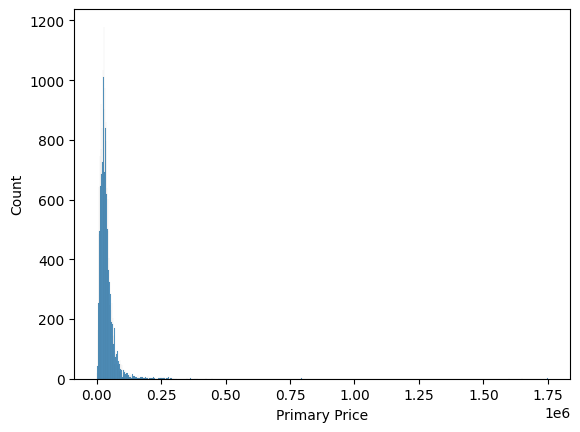

In [8]:
# Sale Price değişkende çok pahalı olan az sayıda arabayı veri setinden çıkartacağım

sns.histplot(final_df["Primary Price"])
print("Value of SalePrice that over 175k:", final_df[(final_df["Primary Price"] > 75000)].shape[0])

In [337]:
final_df = final_df[~(final_df["Primary Price"] > 75000)]

final_df = final_df[~(final_df["Primary Price"] < 5000)]

In [338]:
# variables to be checked for outlier

numerical_ = [col for col in final_df.columns if (final_df[col].nunique() > 2) and (final_df[col].dtype != object)]

final_df[numerical_].describe().T

,count,mean,std,min,25%,50%,75%,max
Mileage,20025.0,50252.451036,36868.184127,0.0,22309.0,42459.000000,70697.0,361662.0
Primary Price,20025.0,31365.164095,15030.699851,5000.0,19990.0,29500.000000,39994.0,75000.0
Year,20025.0,2017.707566,4.445724,1962.0,2016.0,2019.000000,2021.0,2024.0
Engine Size,20025.0,2.890718,4.261456,0.0,2.0,2.500000,3.5,390.0
min_MPG,20025.0,20.865774,6.136729,0.0,17.0,21.000000,24.0,89.0
max_MPG,20025.0,27.744439,6.715143,0.0,24.0,28.000000,31.0,100.0
speed_Transmission,20025.0,7.165471,1.285754,4.0,6.0,7.352941,8.0,10.0


<Axes: xlabel='Engine Size', ylabel='Primary Price'>

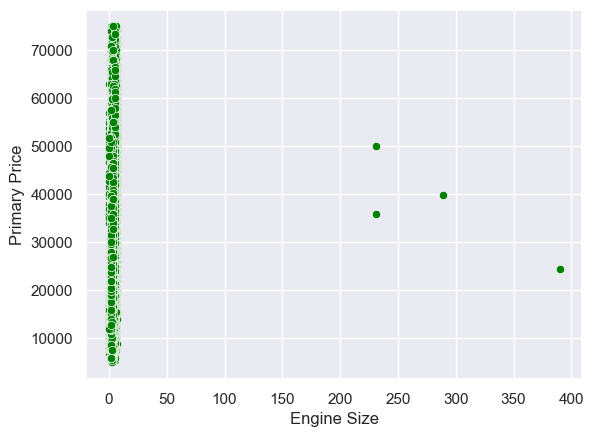

In [340]:
# Engine Size 

sns.scatterplot(x=final_df["Engine Size"], y=final_df["Primary Price"], color='green')

In [341]:
iqr_values(final_df, "Engine Size", upper_quantile=0.99, lower_quantile=0.60, info=True, replace_with_limit=True)

Low Limit : 0.75
 Up Limit : 8.45
 164 observation units under 'Low Limit'
 4 observation units over 'Up Limit'


C:\Users\caner\AppData\Local\Temp\ipykernel_6556\3529754816.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[col].iloc[index] = upper_limit
C:\Users\caner\AppData\Local\Temp\ipykernel_6556\3529754816.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[col].iloc[index] = lower_limit


(0.75, 8.45, 164, 4)

<Axes: xlabel='Mileage', ylabel='Primary Price'>

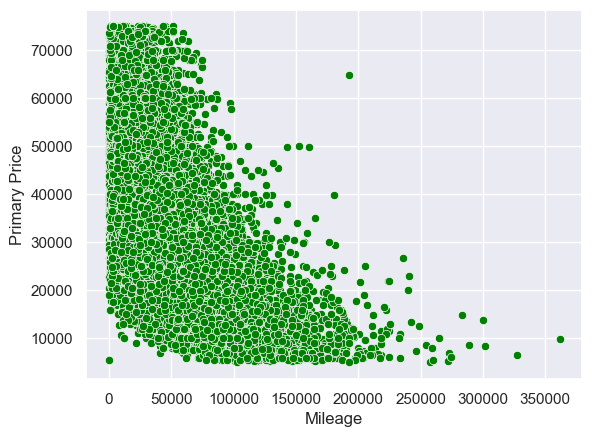

In [342]:
# mileage 

sns.scatterplot(x=final_df["Mileage"], y=final_df["Primary Price"], color='green')

In [343]:
iqr_values(final_df, "Mileage", upper_quantile=1, lower_quantile=0.77, info=True, replace_with_limit=True)

Low Limit : 1164.0399999999936
 Up Limit : 434244.0
 201 observation units under 'Low Limit'
 0 observation units over 'Up Limit'


C:\Users\caner\AppData\Local\Temp\ipykernel_6556\3529754816.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[col].iloc[index] = lower_limit


(1164.0399999999936, 434244.0, 201, 0)

<Axes: xlabel='min_MPG', ylabel='Primary Price'>

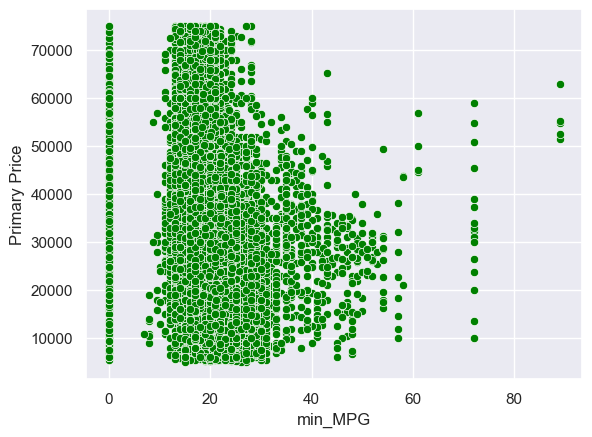

In [344]:
# min_MPG

sns.scatterplot(x=final_df["min_MPG"], y=final_df["Primary Price"], color='green')

In [345]:
iqr_values(final_df, "min_MPG", upper_quantile=0.997, lower_quantile=0.85, info=True, replace_with_limit=True)

C:\Users\caner\AppData\Local\Temp\ipykernel_6556\3529754816.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[col].iloc[index] = lower_limit
C:\Users\caner\AppData\Local\Temp\ipykernel_6556\3529754816.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[col].iloc[index] = upper_limit


Low Limit : 15.5
 Up Limit : 62.427999999999884
 2518 observation units under 'Low Limit'
 21 observation units over 'Up Limit'


(15.5, 62.427999999999884, 2518, 21)

<Axes: xlabel='max_MPG', ylabel='Primary Price'>

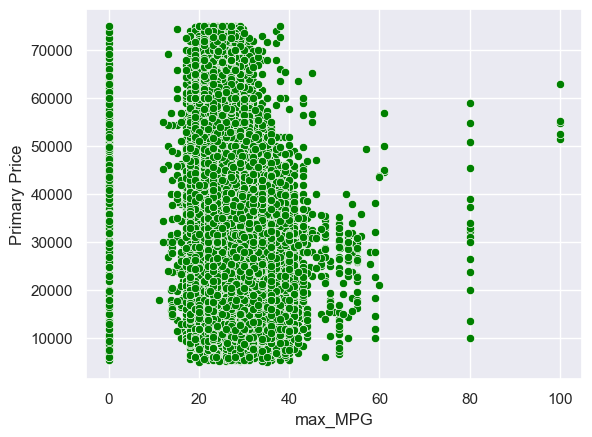

In [346]:
# max_MPG

sns.scatterplot(x=final_df["max_MPG"], y=final_df["Primary Price"], color='green')

In [347]:
iqr_values(final_df, "max_MPG", upper_quantile=0.999, lower_quantile=0.60, info=True, replace_with_limit=True)

C:\Users\caner\AppData\Local\Temp\ipykernel_6556\3529754816.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[col].iloc[index] = lower_limit
C:\Users\caner\AppData\Local\Temp\ipykernel_6556\3529754816.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[col].iloc[index] = upper_limit


Low Limit : 18.5
 Up Limit : 90.04400000004534
 816 observation units under 'Low Limit'
 5 observation units over 'Up Limit'


(18.5, 90.04400000004534, 816, 5)

In [ ]:
final_df = final_df[~(final_df["Year"] < 2003)]

## 3.4- New features

In [348]:
final_df.dropna(inplace=True)

In [349]:
final_df["Model_1"] = final_df["Model"].apply(lambda x : x.split(" ")[0])
final_df["Model_2"] = final_df["Model"].apply(lambda x : x.split(" ")[1] if len(x.split(" ")) > 1 else x.split(" ")[0])

In [350]:
# country?

japan_cars = ['Honda', 'Toyota', 'Mazda', 'Mitsubishi', 'Nissan', 'Suzuki', 'Lexus']

german_cars = ['Ford', 'Audi', 'BMW', 'MINI', 'Porsche', 'Mercedes-Benz', 'Volkswagen']

italian_cars = ['FIAT', 'Maserati', 'Alfa']

american_cars = ['Chevrolet', 'Jeep', 'Cadillac']

lux_cars = ['Maserati', 'Lexus', 'Jaguar', 'Porsche', ]

final_df["japan_cars"] = final_df["Brand"].apply(lambda x : 1 if x in japan_cars else 0)

final_df["german_cars"] = final_df["Brand"].apply(lambda x : 1 if x in german_cars else 0)

final_df["italian_cars"] = final_df["Brand"].apply(lambda x : 1 if x in italian_cars else 0)

final_df["american_cars"] = final_df["Brand"].apply(lambda x : 1 if x in american_cars else 0)

final_df["lux_cars"] = final_df["Brand"].apply(lambda x : 1 if x in lux_cars else 0)

In [351]:
# mileage per year

final_df["NEW_Mileage_per_year"] = final_df["Mileage"] / final_df["Year"]

In [352]:
# total number of features

final_df["feature_size"] = final_df[features].sum(axis=1)

In [353]:
# first owner and no accident

final_df["NEW_first_owner_no_acc"] = final_df["Accidents or damage"] + final_df["1-owner vehicle"]

for index, row in final_df.iterrows():
    value = row["1-owner vehicle"]
    if value == 1:
        if row["NEW_first_owner_no_acc"] != 1:
            final_df.at[index, "NEW_first_owner_no_acc"] = 0

In [354]:
# mean of max mpg and min mpg

final_df["NEW_mpg_mean"] = (final_df["min_MPG"] + final_df["max_MPG"]) / 2

In [355]:
# Front-wheel Drive and Turbo

final_df["NEW_fwd_turbo"] = 0

final_df["NEW_fwd_turbo"] = final_df["Drivetrain"].apply(lambda x : 1 if x == 'Front-wheel Drive' else 0) + final_df["Turbo"]

final_df["NEW_fwd_turbo"] = final_df["NEW_fwd_turbo"].replace({2: 1, 1: 0})

In [357]:
# total number of safety features

final_df["NEW_safety_size"] = final_df["Automatic Emergency Braking"] + final_df["Backup Camera"] + final_df["Stability Control"]

In [358]:
# is new car?

final_df["NEW_is_new_car"] = final_df["Year"].apply(lambda x : 1 if x > 2020 else 0)

In [359]:
# is old car?

final_df["NEW_is_old_car"] = final_df["Year"].apply(lambda x : 1 if x < 2015 else 0)

In [360]:
# classification according to vehicle mileage

final_df["NEW_Mileage"] = final_df["Mileage"].apply(lambda x: 9 if x < 10000
                          else 8 if (x < 20000) and (x > 10000)
                          else 7 if (x < 30000) and (x > 20000)
                          else 6 if (x < 40000) and (x > 30000)
                          else 5 if (x < 50000) and (x > 40000)
                          else 4 if (x < 60000) and (x > 50000)
                          else 3 if (x < 70000) and (x > 60000)
                          else 2 if (x < 80000) and (x > 70000)
                          else 1 if (x < 90000) and (x > 80000)
                          else 0)

* * *
# 4- MODEL

In [365]:
# X-y

X = final_df.drop(["Primary Price", "Model"], axis=1)
y = final_df["Primary Price"]

In [367]:
# one-hot encoding

one_hot_encoding_list = [col for col in X.columns if final_df[col].dtype == object]

X = pd.get_dummies(X, columns=one_hot_encoding_list, drop_first=True, dummy_na=False)

In [368]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=97)

* *
## 4.1- LightGBM

In [369]:
original_columns = X_train.columns

X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [388]:
model = lgb.LGBMRegressor()

hyperparameters = {
    'boosting_type' : ['gbdt'], 
    'objective' : ['regression'], 
    'max_bin' : [155], 
    'num_leaves' : [32],
    'max_depth' : [17], 
    'subsample' : [0.63], 
    'subsample_freq' : [3], 
    'feature_fraction_seed' : [3], 
    'learning_rate' : [0.01],
    'n_estimators' : [3200], 
    'reg_alpha' : [0.008], 
    'reg_lambda' : [0.008], 
    'colsample_bytree' : [0.58], 
    'min_child_samples' : [14], 
    'min_child_weight' : [0.92],
    'min_split_gain' : [0.68],
    'n_jobs' : [-1],
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=hyperparameters, cv=2, verbose=False, error_score='raise').fit(X_train, y_train)

c:\Users\caner\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [389]:
model_dict = {"model": random_search.best_estimator_, "features_": original_columns}

# save model with pickle
import pickle
with open("model.pkl", "wb") as f:
    pickle.dump(model_dict, f)

In [391]:
# final model

lgbm_final = model.set_params(**random_search.best_params_)
lgbm_final.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='rmse', verbose=False)

c:\Users\caner\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMRegressor(colsample_bytree=0.58, feature_fraction_seed=3,
              learning_rate=0.01, max_bin=155, max_depth=17,
              min_child_samples=14, min_child_weight=0.92, min_split_gain=0.68,
              n_estimators=3200, num_leaves=32, objective='regression',
              reg_alpha=0.008, reg_lambda=0.008, subsample=0.63,
              subsample_freq=3)

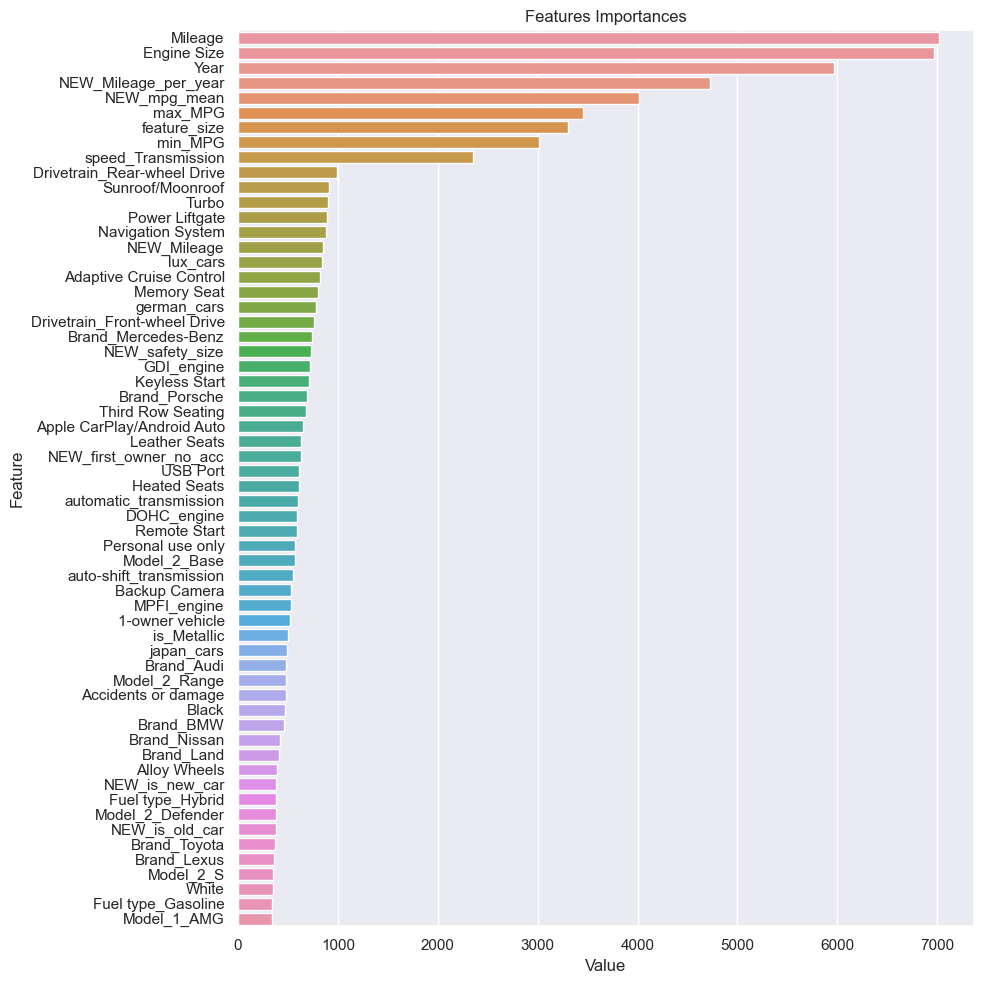

In [393]:
plot_importance(lgbm_final, original_columns, feature_num=60,save=False)



Train Error:

Mean Absolute Error (MAE): 1912.607837489576
Mean Squared Error (MSE): 6725334.836160548
Root Mean Squared Error (RMSE): 2593.325054088004
R^2 Score: 0.9700284152749284
RMSLE :  0.09674012681519355


Test Error:

Mean Absolute Error (MAE): 2574.660268818505
Mean Squared Error (MSE): 13721023.846548812
Root Mean Squared Error (RMSE): 3704.1900392054417
R^2 Score: 0.9393980509917057
RMSLE :  0.12230643558962508


Areas under & between curves: 11805731.02

Area Under Train set:
Area Under Test set: 13935603.01
Area Between curves: 2129871.99


Error Graphic for per iter:


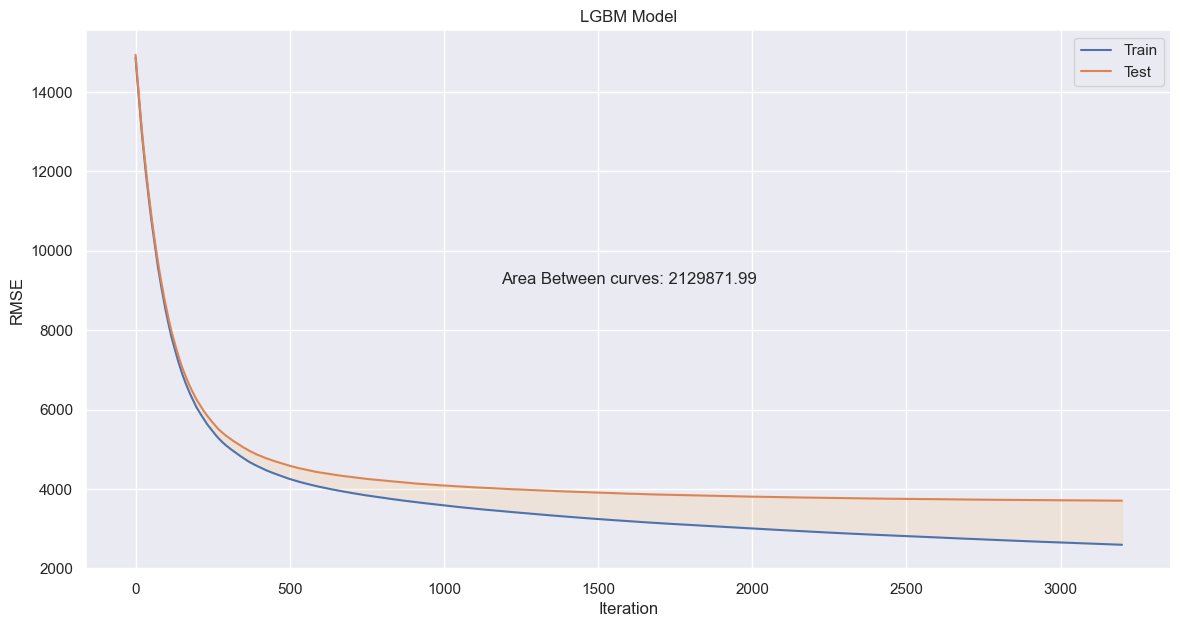

In [395]:
error_metrics(y_train_or_test=[y_train, y_test], 
              x_train_or_test=[X_train, X_test],
              model_type="LGBM", 
              title=["Train", "Test"],
              final_model=lgbm_final, 
              plot_graph=True, figure_size=14, figure_height=7)